In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import koreanize_matplotlib
from konlpy.tag import Okt
from gensim.models import Word2Vec
from collections import Counter

from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, GlobalAveragePooling1D, GlobalMaxPooling1D, Dense, Dropout, Flatten
from tensorflow.keras.layers import SimpleRNN, LSTM, GRU, Conv1D
from tensorflow.keras.callbacks import EarlyStopping

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import Adam

In [3]:
# 데이터 로드
df = pd.read_csv("https://raw.githubusercontent.com/hongsukyi/Lectures/main/data/nsmc.txt", sep="\t")
df = df.dropna().drop_duplicates(['document']).reset_index(drop=True)

df['word_count'] = df['document'].apply(lambda x: len(str(x).split()))
df_sorted = df.sort_values(by='word_count', ascending=False).reset_index(drop=True)

df=df_sorted[:10000].copy()

df.replace("", float("NaN"), inplace=True)
df = df.dropna().reset_index(drop=True)
print('결측치 처리 이후:',len(df))
df = df.drop_duplicates(['document']).reset_index(drop=True)
print('중복 제거 이후:',len(df))
df['document'] = df['document'].str.replace(r"[^ㄱ-ㅎㅏ-ㅣ가-힣 ]", "", regex=True)
print('한글 아닌 문자 제거 이후:',len(df))

df['document'] = df['document'].apply(lambda x: ' '.join([token for token in x.split() if len(token) > 2]))
print('리뷰 길이가 짧은 것 제거 :',len(df))

df.head()

결측치 처리 이후: 10000
중복 제거 이후: 10000
한글 아닌 문자 제거 이후: 10000
리뷰 길이가 짧은 것 제거 : 10000


,id,document,label,word_count
0,6928782,쌕기들이 종교랑 보솤ㅋㅋㅋㅋㅋ 그라제 우덜이 미군이 써보지도 완전히 전쟁도 있었당께...,0,41
1,8330404,정유미 정준영 부부막둥이 윤한부부 나오면 채널로 최초로 부부가 재미없음 막둥이 윤한...,0,40
2,8525988,측정용 영화임 당신은 마음이 남에게 상처를 못하는 당신은 인문학예술은 당신의 분야가...,0,40
3,8153927,황당한 쓰레기같은 스토리 수준을 초월한 칭찬해 차라리 디워는 나와서 신기하기라도 도...,0,40
4,8120918,남자고 아비라면 김윤진 역보다 어미니의 아들입장이라면 저보다 평만보면 공자시구만ㅋㅋ...,1,40


In [4]:
# 짧은 문장 제거
okt = Okt()
def token_count(text):
    return len(okt.morphs(text, stem=True))

df = df[df['document'].apply(lambda x: token_count(x) >= 3)].reset_index(drop=True)

print(f"최종 데이터 크기: {len(df)}")

최종 데이터 크기: 9994


In [5]:
stopwords = ['의', '가', '이', '은', '들', '는', '좀', '잘', '걍', '과', '도', '를', '으로',
             '자', '에', '와', '한', '하다', '을', '적', '로', '인', '만',
             '다', '이다', '에서', '되다', '하고', '않다', '못', '고', '안', '것', '나', '그']

def clean_tokenize(text):
    tokens = okt.morphs(text, stem=True)
    return [w for w in tokens if w not in stopwords]

df['tokens'] = df['document'].apply(clean_tokenize)


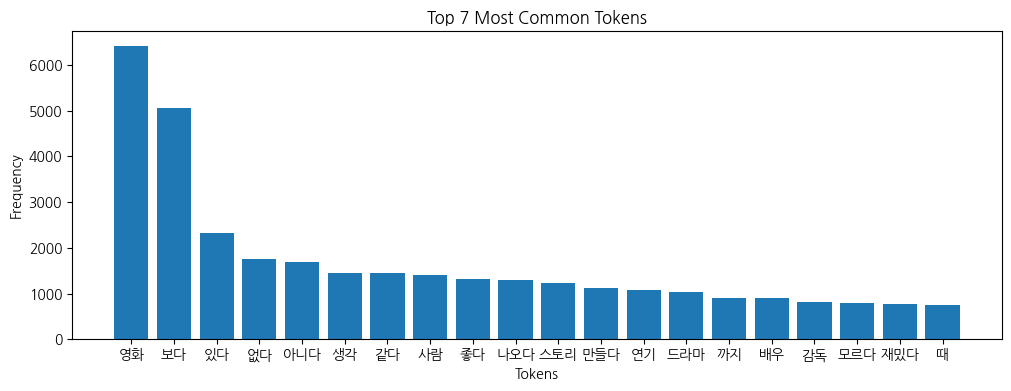

In [6]:
df_samples=df['tokens']
all_tokens = [token for tokens in df_samples for token in tokens]

counter = Counter(all_tokens)
common_words = counter.most_common(20) 
words, freqs = zip(*common_words)

plt.figure(figsize=(12,4))
plt.bar(words, freqs)
plt.title("Top 7 Most Common Tokens")
plt.xlabel("Tokens")
plt.ylabel("Frequency")
plt.show()

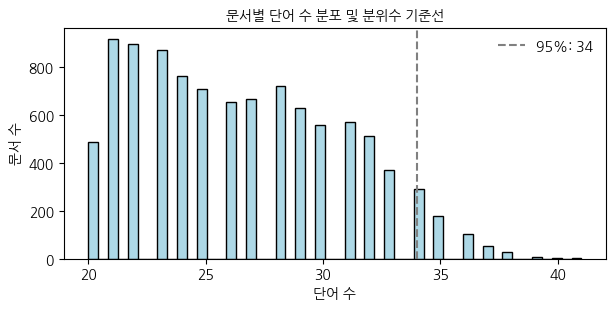

In [7]:
## 패딩을 위한 95% 분위값 출력
q95= df['word_count'].quantile([0.95])

plt.figure(figsize=(7, 3))
plt.hist(df['word_count'], bins=50, color='lightblue', edgecolor='black')


plt.axvline(x=q95.iloc[0], color='gray', linestyle='--', label=f'95%: {int(q95.iloc[0])}')
plt.title('문서별 단어 수 분포 및 분위수 기준선', fontsize=10)
plt.xlabel('단어 수', fontsize=10)
plt.ylabel('문서 수', fontsize=10)
plt.legend(frameon=False,fontsize=10)
plt.grid(False)
plt.show()

In [8]:
max_len = 35
embedding_dim = 64

In [9]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df['tokens'].apply(lambda x: ' '.join(x)))

sequences = tokenizer.texts_to_sequences(df['tokens'].apply(lambda x: ' '.join(x)))

X = pad_sequences(sequences, maxlen=max_len, padding='post')
y = np.array(df['label'])
print(f"X shape: {X.shape}, y shape: {y.shape}")

X shape: (9994, 35), y shape: (9994,)


In [10]:
vocab_size = len(tokenizer.word_index) + 1
print(f"vocab_size: {vocab_size}")
print(f"max index in sequences: {np.max(X)}")

vocab_size: 20272
max index in sequences: 20271


In [24]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

d1= 128
d2= 64
drop_rate = 0.3 
kernel_size = 3  # CNN 필터 크기
filters = 128    # CNN 필터 수

In [40]:
m_mlp = Sequential([
    Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_len),
    Dropout(drop_rate),
    GlobalAveragePooling1D(),
    Dense(d1, activation='relu', kernel_regularizer=regularizers.l2(0.0001)),
    Dropout(drop_rate),
    Dense(d2, activation='relu', kernel_regularizer=regularizers.l2(0.0001)),
    Dense(1, activation='sigmoid')
])

m_rnn = Sequential([
    Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_len),
    Dropout(drop_rate),
    SimpleRNN(64, return_sequences=False),  # RNN 유닛 수는 필요시 조정 가능
    Dense(d1, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    Dropout(drop_rate),
    Dense(d2, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    Dense(1, activation='sigmoid')
])
m_rnn0 = Sequential([
    Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_len),
    Dropout(drop_rate),
    SimpleRNN(64, return_sequences=False),  # RNN 유닛 수는 필요시 조정 가능
    Dense(d1, activation='relu', kernel_regularizer=regularizers.l2(0.0001)),
    Dropout(drop_rate),
    Dense(d2, activation='relu', kernel_regularizer=regularizers.l2(0.0001)),
    Dense(1, activation='sigmoid')
])

m_gru = Sequential([
    Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_len),
    Dropout(drop_rate),
    GRU(64, return_sequences=False),  # RNN 유닛 수는 필요시 조정 가능
    Dense(d1, activation='relu', kernel_regularizer=regularizers.l2(0.0001)),
    Dropout(drop_rate),
    Dense(d2, activation='relu', kernel_regularizer=regularizers.l2(0.0001)),
    Dense(1, activation='sigmoid')
])

m_lstm = Sequential([
    Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_len),
    Dropout(drop_rate),
    LSTM(64, return_sequences=False),  # RNN 유닛 수는 필요시 조정 가능
    Dense(d1, activation='relu', kernel_regularizer=regularizers.l2(0.0001)),
    Dropout(drop_rate),
    Dense(d2, activation='relu', kernel_regularizer=regularizers.l2(0.0001)),
    Dense(1, activation='sigmoid')
])

m_cnn = Sequential([
    Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_len),
    #Dropout(drop_rate),
    Conv1D(filters=filters, kernel_size=kernel_size, activation='relu', padding='same'),
    GlobalMaxPooling1D(),
    Dense(d1, activation='relu', kernel_regularizer=regularizers.l2(0.0001)),
    #Dropout(drop_rate),
    Dense(d2, activation='relu', kernel_regularizer=regularizers.l2(0.0001)),
    Dense(1, activation='sigmoid')
])


In [41]:
model_dict = { 
    'MLP': m_mlp, 
    'SimpleRNN': m_rnn, 
    'LSTM': m_lstm,  
    'GRU': m_gru, 
    'CNN1D': m_cnn
}

In [42]:
choice = 'CNN1D'
model = model_dict[choice]
model.summary()

Model: "sequential_37"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_38 (Embedding)    (None, 35, 64)            1297408   
                                                                 
 conv1d_6 (Conv1D)           (None, 35, 128)           24704     
                                                                 
 global_max_pooling1d_5 (Glo  (None, 128)              0         
 balMaxPooling1D)                                                
                                                                 
 dense_111 (Dense)           (None, 128)               16512     
                                                                 
 dropout_75 (Dropout)        (None, 128)               0         
                                                                 
 dense_112 (Dense)           (None, 64)                8256      
                                                     

In [43]:
#model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
optimizer = Adam(learning_rate=0.0002)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
history = model.fit(X_train, y_train, epochs=30, batch_size=64,
                    validation_split=0.2, callbacks=[early_stop], verbose=1)


Epoch 1/30
100/100 [==============================] - 3s 21ms/step - loss: 0.7089 - accuracy: 0.5378 - val_loss: 0.7084 - val_accuracy: 0.5216
Epoch 2/30
100/100 [==============================] - 2s 18ms/step - loss: 0.6902 - accuracy: 0.5589 - val_loss: 0.6777 - val_accuracy: 0.6460
Epoch 3/30
100/100 [==============================] - 2s 18ms/step - loss: 0.5496 - accuracy: 0.8111 - val_loss: 0.5058 - val_accuracy: 0.7711
Epoch 4/30
100/100 [==============================] - 2s 20ms/step - loss: 0.2831 - accuracy: 0.9145 - val_loss: 0.4439 - val_accuracy: 0.8118
Epoch 5/30
100/100 [==============================] - 2s 18ms/step - loss: 0.1314 - accuracy: 0.9747 - val_loss: 0.4666 - val_accuracy: 0.8168
Epoch 6/30
100/100 [==============================] - 2s 19ms/step - loss: 0.0621 - accuracy: 0.9922 - val_loss: 0.5026 - val_accuracy: 0.8099
Epoch 7/30
100/100 [==============================] - 2s 18ms/step - loss: 0.0371 - accuracy: 0.9991 - val_loss: 0.5383 - val_accuracy: 0.8061

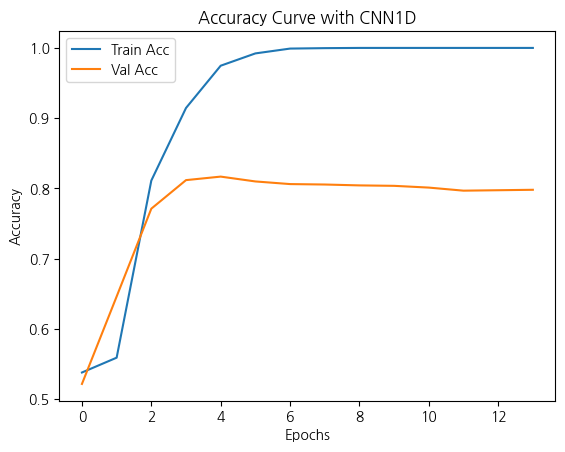

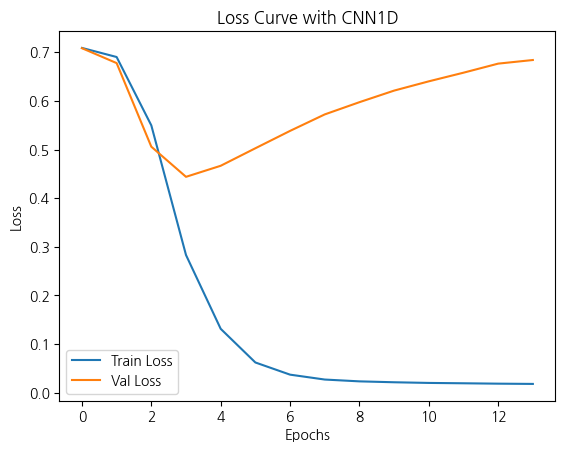

Test Accuracy: 0.8149, Loss: 0.4278


In [44]:
# Accuracy
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title(f"Accuracy Curve with {choice}")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

# Loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title(f"Loss Curve with {choice}")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

# 최종 평가
loss, acc = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Accuracy: {acc:.4f}, Loss: {loss:.4f}")
